# Visualisation of 1D model output

**Date:** 2025-12-01

**Authors:** Damien Bouffard

**Summary:** This notebook provides tools to visualise 1D lake model output (Simstrat-like `T_out.dat`).

## Content:

This notebook helps you create visualizations of lake temperature and water currents. You can:

1. **Plot time series** showing how temperature changes over time at a specific location
2. **Plot temeperature heatmap** plot temperature heatmap (depth vs time)
3. **evaluate climatology** showing how the cross-section changes over time

## Available Functions:

- `plot_temperature_heatmap(df, years=None, ...)` — plot temperature heatmap (depth vs time).
- `plot_temperature_at_depth(df, depth, ...)` — extract and plot a time series at the nearest available depth (with aggregation options).
- `plot_temperature_climatology(df, depth, ...)` — compute and plot daily-of-year climatology (mean, std, min, max) with optional baseline-year overlay.
- `compare_heatmaps(path1, path2, ...)` — load two site outputs and plot their difference heatmap (restricted to shallowest system).
- `plot_two_sites_at_depth(path1, path2, depth, ...)` — extract and plot aligned time series from two sites at a given depth.


## Before You Start:

**No Python knowledge needed!** Just follow these steps:
1. Run each cell in order (click the ▶️ button or press Shift+Enter)
2. Change the values in the examples to customize your visualizations
3. Look for the sections marked "👉 CUSTOMIZE HERE" to modify parameters

**Remaining tasks:** 
- add functions to a python scripts DONE
- save figures and data
- comment the codes for beginners (as in 3D_xxx)



In [1]:
# import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

from functions_1D import plot_temperature_heatmap, plot_temperature_at_depth, plot_temperature_climatology, compare_heatmaps, plot_two_sites_at_depth

In [2]:
# Load data
path = 'data/Geneva'
# Adjust the path - use the correct relative path from your notebook location
data_path = os.path.join(os.path.dirname(os.getcwd()), path, 'T_out.dat')

df = pd.read_csv(data_path)
df['Datetime'] = pd.Timestamp('1981-01-01') + pd.to_timedelta(df['Datetime'], unit='D')
df

,Datetime,-309.000,-308.000,-307.000,-306.000,-305.000,-304.000,-303.000,-302.000,-301.000,...,-9.000,-8.000,-7.000,-6.000,-5.000,-4.000,-3.000,-2.000,-1.000,-0.000
0,1981-01-02 01:00:02.880000000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,...,5.5154,5.5198,5.5242,5.5286,5.5330,5.5374,5.5418,5.5462,5.5506,5.5539
1,1981-01-02 04:00:02.879999999,4.5001,4.5001,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,...,5.5152,5.5166,5.5155,5.5143,5.5124,5.5101,5.5072,5.5030,5.4950,5.4820
2,1981-01-02 07:00:02.880000000,4.5003,4.5002,4.5001,4.5001,4.5000,4.5000,4.5000,4.5000,4.5000,...,5.4946,5.4938,5.4925,5.4908,5.4887,5.4857,5.4826,5.4770,5.4682,5.4536
3,1981-01-02 10:00:02.880000000,4.5004,4.5002,4.5001,4.5001,4.5001,4.5000,4.5000,4.5000,4.5000,...,5.4727,5.4719,5.4709,5.4697,5.4683,5.4664,5.4640,5.4606,5.4542,5.4468
4,1981-01-02 13:00:02.880000000,4.5004,4.5003,4.5002,4.5001,4.5001,4.5001,4.5001,4.5000,4.5000,...,5.4658,5.4654,5.4647,5.4639,5.4627,5.4606,5.4584,5.4546,5.4480,5.4373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131195,2025-11-26 10:00:02.880000138,7.1850,7.1849,7.1848,7.1847,7.1847,7.1846,7.1846,7.1845,7.1845,...,10.3520,10.3520,10.3500,10.3490,10.3480,10.3460,10.3440,10.3410,10.3360,10.3290
131196,2025-11-26 13:00:02.880000138,7.1850,7.1849,7.1848,7.1847,7.1847,7.1846,7.1846,7.1845,7.1845,...,10.3460,10.3450,10.3440,10.3430,10.3420,10.3410,10.3390,10.3370,10.3340,10.3260
131197,2025-11-26 16:00:02.880000138,7.1850,7.1849,7.1848,7.1847,7.1847,7.1846,7.1846,7.1845,7.1845,...,10.3370,10.3360,10.3350,10.3340,10.3320,10.3300,10.3270,10.3240,10.3190,10.3130
131198,2025-11-26 19:00:02.880000138,7.1850,7.1849,7.1848,7.1847,7.1847,7.1846,7.1846,7.1846,7.1845,...,10.3200,10.3190,10.3170,10.3150,10.3130,10.3110,10.3090,10.3050,10.3010,10.2970


<Axes: title={'center': 'Temperature  (2020-01-01 to 2022-12-31)'}, xlabel='Date', ylabel='Depth (m)'>

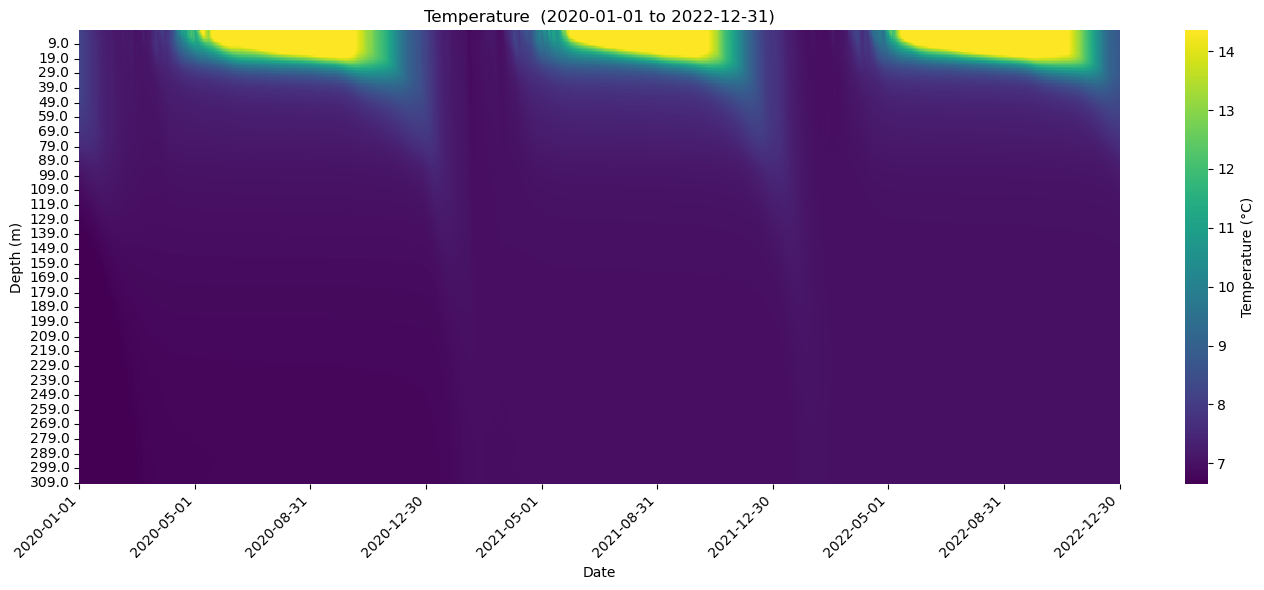

In [3]:
# Example usage (uncomment to run):
#plot_temperature_heatmap(df)                       # plot all data
# plot_temperature_heatmap(df, years=2024)           # single year
plot_temperature_heatmap(df, years=(2020,2022))    # time period from 2020 to 2022

/Users/bouffada/Documents/Git/Peak_alplakes/scripts/functions_1D.py:162: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts_agg = ts.resample(freq).mean()


<Axes: title={'center': 'Temperature at depth ~0.0 m'}, xlabel='Date', ylabel='Temperature (°C)'>

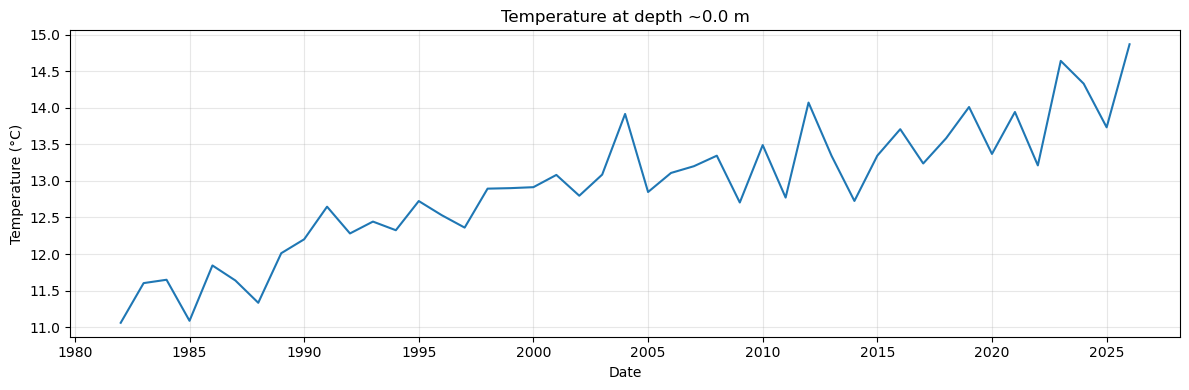

In [4]:
# Example usage:
# plot_temperature_at_depth(df, depth=1.0, agg='daily')
plot_temperature_at_depth(df, depth=0, agg='yearly', method='mean')

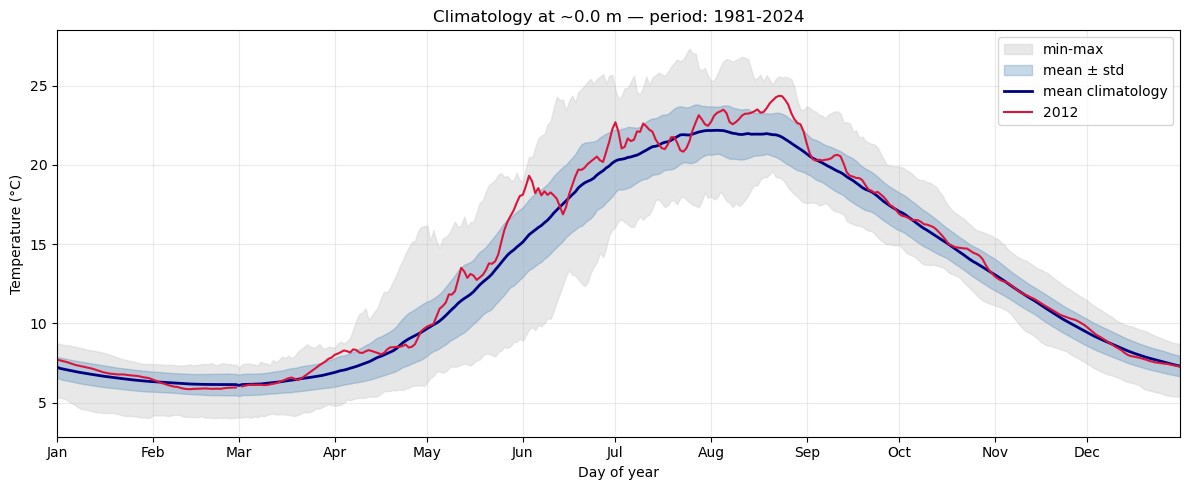

In [5]:
# Example usage:
ax, clim = plot_temperature_climatology(df, depth=0, period=(1981,2024), baseline_year=2012, method='mean')

(<Axes: title={'center': 'Difference heatmap: data/Geneva minus data/Upper_Lugano (depths ≤ 287.0 m)'}, xlabel='Date', ylabel='Depth (m)'>,
 Datetime    1981-01-02 01:00:02.880000000  1981-01-02 04:00:02.879999999  \
 Depth_plot                                                                 
 0.0                                   0.0                         0.0046   
 1.0                                   0.0                         0.0089   
 2.0                                   0.0                         0.0118   
 3.0                                   0.0                         0.0133   
 4.0                                   0.0                         0.0144   
 ...                                   ...                            ...   
 283.0                                 0.0                         0.0000   
 284.0                                 0.0                         0.0000   
 285.0                                 0.0                         0.0000   
 286.0       

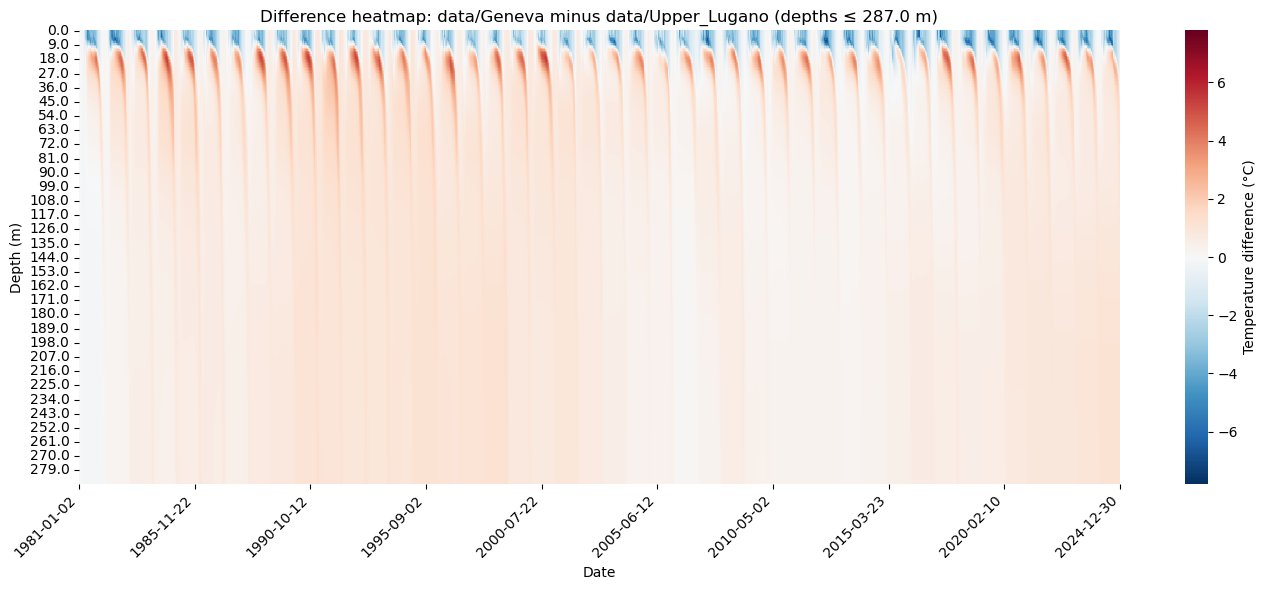

In [6]:
compare_heatmaps('data/Geneva', 'data/Upper_Lugano', years=(1981, 2024))         # single year

/Users/bouffada/Documents/Git/Peak_alplakes/scripts/functions_1D.py:478: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s1 = s1.resample(freq).mean()
/Users/bouffada/Documents/Git/Peak_alplakes/scripts/functions_1D.py:479: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s2 = s2.resample(freq).mean()


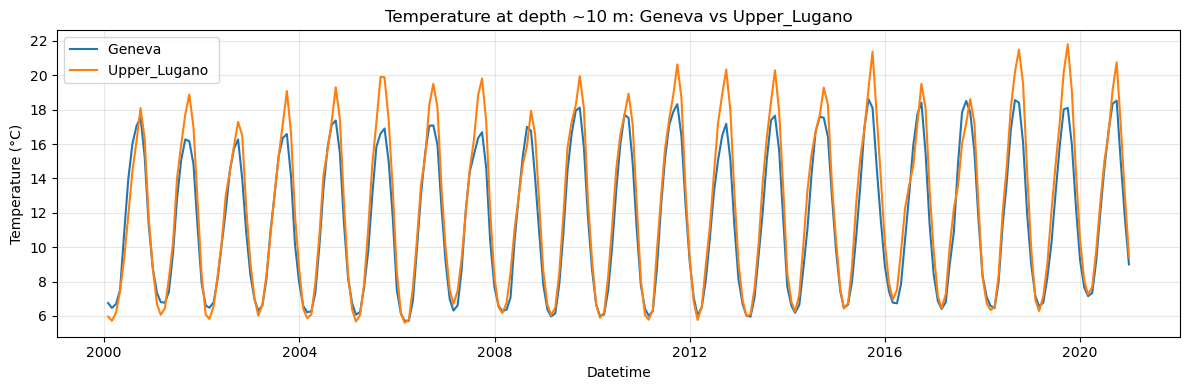

In [7]:
# Example usage:
ax, df = plot_two_sites_at_depth('data/Geneva', 'data/Upper_Lugano', depth=10, years=(2000,2020), agg='monthly', savepath='figures/compare_10m.png')